# Housing prices in Hyderabad, India

## Project Objective 🎯

The objective of this project is to develop a regression model to predict housing prices in Hyderabad, India. Using features such as the property's area, location, number of bedrooms, and available amenities, the model will aim to estimate the market value of a property as accurately as possible.

- This predictive model will be a valuable tool for:
- Home Buyers and Sellers: To obtain an objective price estimate for a property.
- Real Estate Agents: To assist with property valuation and client advisory.
- Investors: To identify potentially undervalued or overvalued properties in the market.

## 1. Exploratory Data Analysis (EDA)

### 1.1 Loading the initial Dataset.

In [1]:
import pandas as pd
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

import sys
sys.path.append('../../src/utils')

# Utilities
from housing_prices_column_definition import Column

# Load dataset from CSV format
rawDataPath = '../../datasets/raw/hyderabad_house_price_original.csv'
datasetPath = '../../datasets/processed/housing_prices/hyderabad_house_price_original.parquet'

try:
    raw_data = pd.read_csv(rawDataPath, dtype=Column.get_dtypes_dict())
    raw_data.to_parquet(datasetPath)
except (FileNotFoundError, ValueError) as e:
    logging.exception(f"Error trying to load the dataset '{rawDataPath}'. Cause: {e}")


# raw_data.info()
Column.show_expected_columns_details()


Column: AC
  - Description: A flag indicating if air conditioning is included.
  - Expected Type: int64
  - Expected Format: {:.0f}

Column: Area
  - Description: The area of the property in square feet (ft²).
  - Expected Type: int64
  - Expected Format: {:,.0f}

Column: ATM
  - Description: A flag for the availability of a nearby ATM.
  - Expected Type: int64
  - Expected Format: {:.0f}

Column: BED
  - Description: A flag indicating if a bed is included.
  - Expected Type: int64
  - Expected Format: {:.0f}

Column: Cafeteria
  - Description: A flag for the availability of a cafeteria.
  - Expected Type: int64
  - Expected Format: {:.0f}

Column: CarParking
  - Description: A flag for the availability of car parking.
  - Expected Type: int64
  - Expected Format: {:.0f}

Column: Children'splayarea
  - Description: A flag for the availability of a children's play area.
  - Expected Type: int64
  - Expected Format: {:.0f}

Column: ClubHouse
  - Description: A flag for the availability 

**Initial Observation:**

- The dataset has been loaded successfully. 
- The data types in the dataset match the expected data types.
- It contains 2518 samples (rows) and 40 dimensions (columns).
- There are no columns with missing values.
- The Location column is object and the others are numeric type. 
- Most columns represent whether the house includes a specific amenity.
- Other columns refer to the area and number of bedrooms in the houses.
- The Price column will be our target.

### 1.2 Descriptive Statistics for ALL Columns.

In [2]:
dataset = pd.read_parquet(datasetPath)
    
all_stats = dataset.describe(include='all')
styled_all_stats = all_stats.style.format(Column.get_format_dict(), na_rep="-")

display(styled_all_stats)

,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,RainWaterHarvesting,IndoorGames,ShoppingMall,Intercom,SportsFacility,ATM,ClubHouse,School,24X7Security,PowerBackup,CarParking,StaffQuarter,Cafeteria,MultipurposeRoom,Hospital,WashingMachine,Gasconnection,AC,Wifi,Children'splayarea,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
count,"$ 2,518.0000","2,518",2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518,2518
unique,-,-,243,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
top,-,-,Kukatpally,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
freq,-,-,166,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
mean,"$ 9,818,379.6366","1,645",-,3,0,0,1,1,1,1,1,1,0,1,1,0,1,0,1,1,1,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0
std,"$ 8,777,112.8774",746,-,1,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
min,"$ 2,000,000.0000",500,-,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25%,"$ 4,760,000.0000","1,160",-,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50%,"$ 7,754,000.0000","1,500",-,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
75%,"$ 10,900,000.0000","1,829",-,3,0,0,1,1,1,1,1,1,0,1,1,0,1,0,1,1,1,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0


| Column    | Detailed Observation | 
| :---      | :---                 |
| **Price**     | The average price (mean) is $9.8M, but the middle price (median/50%) is only $7.75M. Furthermore, the standard deviation is $8.8M, which is almost as large as the mean itself. This confirms the prices are extremely spread out and inconsistent, caused by a few very expensive properties (outliers), with the most expensive one costing $165M. | 
| **Area**     | The mean (1,645 ft²)  is slightly above the median (1,500), and the max value (9,400) is significantly larger than 75% of the data (1,829). This indicates the distribution is right-skewed with the presence of large outliers. The high standard deviation (std of 746) also confirms a wide spread in property sizes.  | 
| **Location**     | This column has high cardinality, with 243 unique locations. This can be challenging for modeling (e.g., One-Hot Encoding). The top location, "Kukatpally", appears 166 times (freq), showing a notable concentration of listings in that single area. | 
| **No. of Bedrooms**             | The data is heavily concentrated. The mean, median (50%), and 75th percentile are all 3. This shows that the vast majority of properties have 3 bedrooms or fewer, making properties with the max of 8 clear outliers. |
| **Amenities**     | Multiple amenity columns (e.g., `MaintenanceStaff`, `Gymnasium`, `SwimmingPool`) are expected to be binary value (0, 1) but contain the value **`9`**. | 

### 1.3 Verifying wrong data.

#### 1.3.1 Checking missing values.

In [3]:
print("Total Missing values:", dataset.isnull().sum().sum())
dataset.isnull().sum()

Total Missing values: 0


Price                  0
Area                   0
Location               0
No. of Bedrooms        0
Resale                 0
MaintenanceStaff       0
Gymnasium              0
SwimmingPool           0
LandscapedGardens      0
JoggingTrack           0
RainWaterHarvesting    0
IndoorGames            0
ShoppingMall           0
Intercom               0
SportsFacility         0
ATM                    0
ClubHouse              0
School                 0
24X7Security           0
PowerBackup            0
CarParking             0
StaffQuarter           0
Cafeteria              0
MultipurposeRoom       0
Hospital               0
WashingMachine         0
Gasconnection          0
AC                     0
Wifi                   0
Children'splayarea     0
LiftAvailable          0
BED                    0
VaastuCompliant        0
Microwave              0
GolfCourse             0
TV                     0
DiningTable            0
Sofa                   0
Wardrobe               0
Refrigerator           0


#### 1.3.2 Checking the magnitude.   

In [4]:
cols_to_check = [Column.PRICE.name, Column.AREA.name, Column.NO_OF_BEDROOMS.name]

filas_negativas = dataset[(dataset[cols_to_check] < 0).any(axis=1)]

filas_negativas.head()

,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator


### 1.4 Checking Outliers.

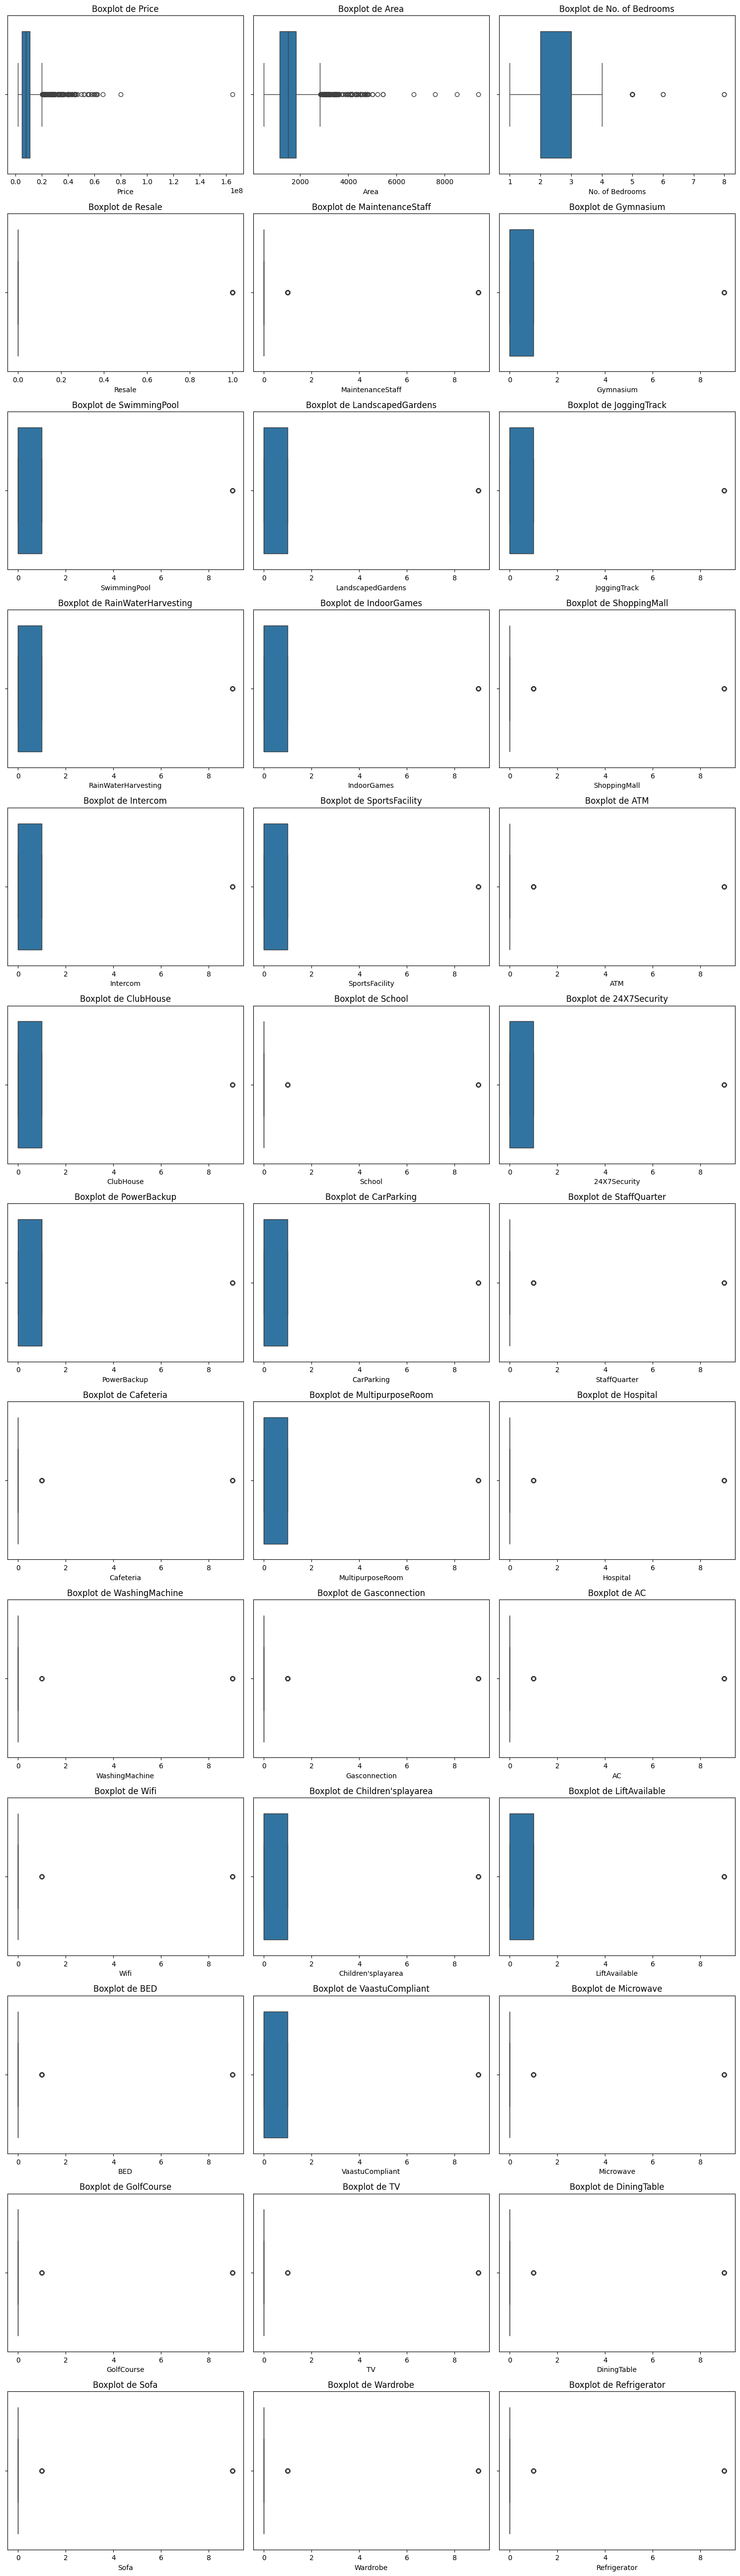

In [5]:
numeric_cols = dataset.select_dtypes(include=["int64", "float64"]).columns
n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()


for i, col in enumerate(numeric_cols):
    sns.boxplot(x=dataset[col], ax=axes[i])
    
    axes[i].set_title(f"Boxplot de {col}")


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()

### 1.5 Distribution of data by column

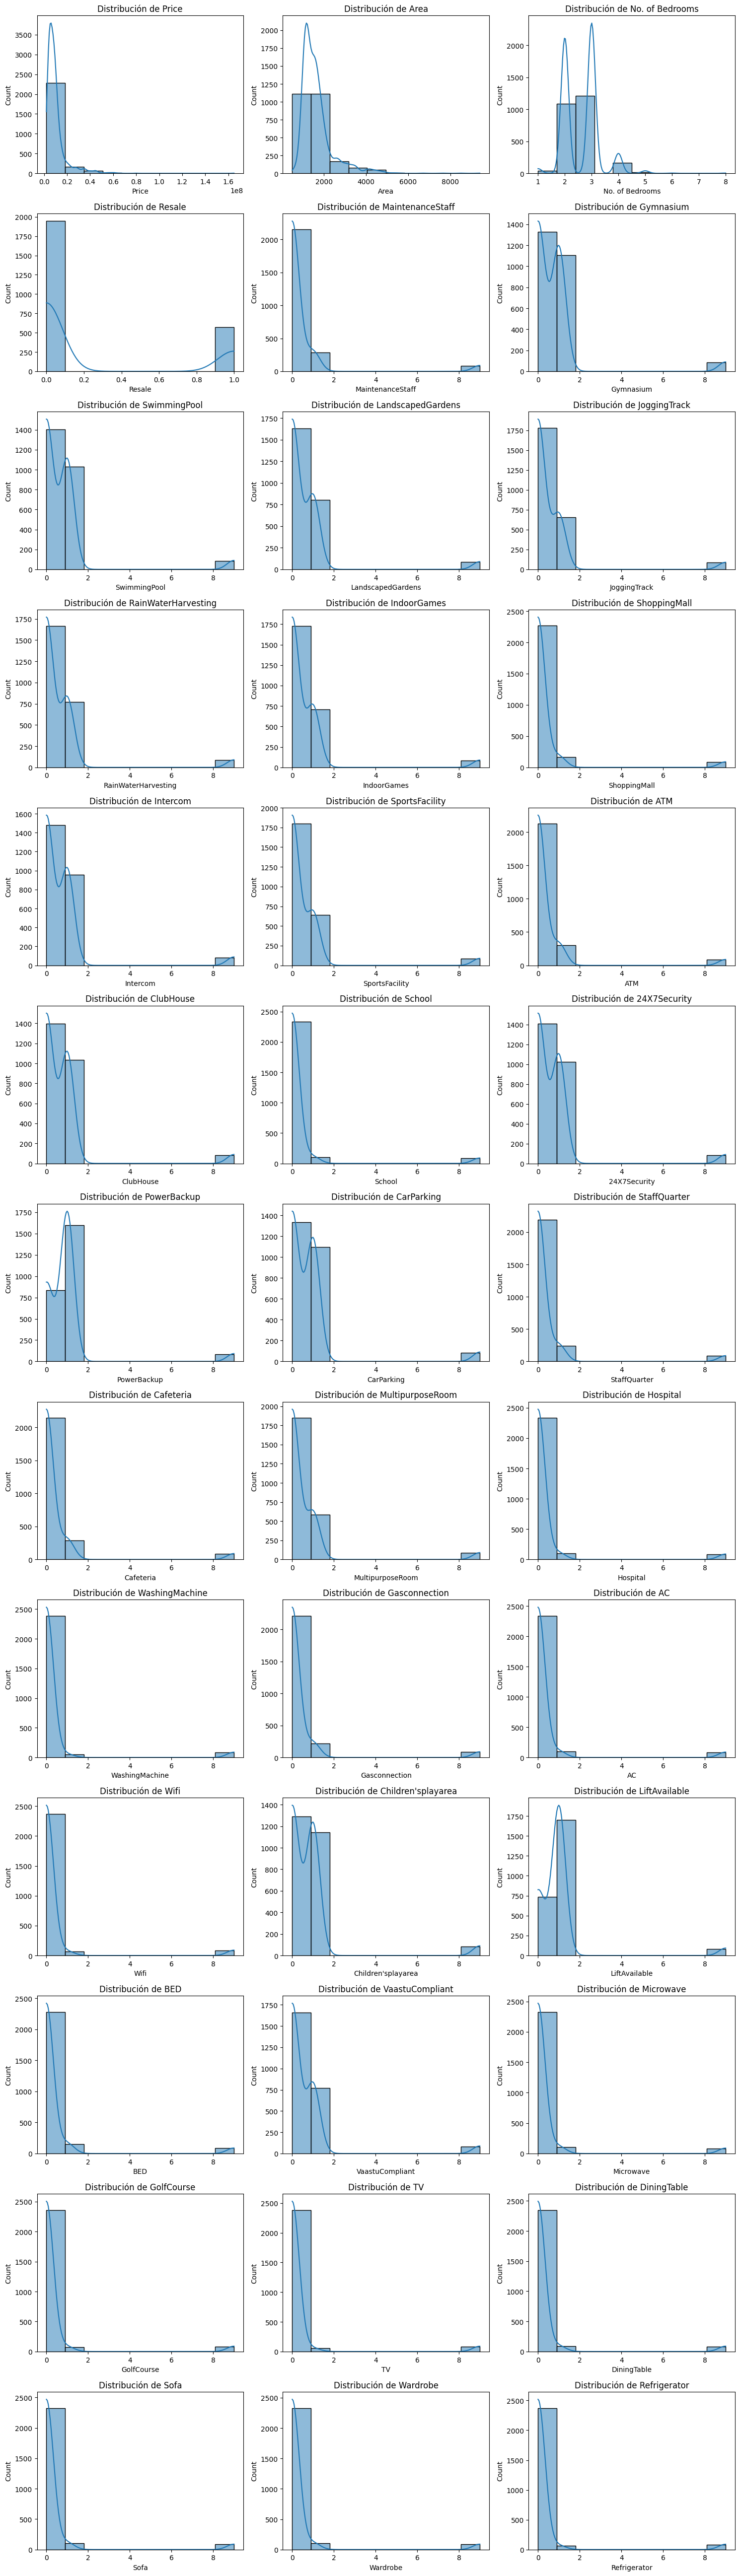

In [6]:
# Select the numeric columns
numeric_cols = dataset.select_dtypes(include=["int64","float64"]).columns

# Layout de subplots columns and rows
n_cols = 3  
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()  # lo convertimos a 1D para iterar fácil

# Create histogram in each subplot
for i, col in enumerate(numeric_cols):
    sns.histplot(data=dataset, x=col, bins=10, ax=axes[i], kde=True)
    axes[i].set_title(f"Distribución de {col}")

# Remove empty axles if there are any left over
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 1.6 Correlation Matrix

Correlation is a statistical measure that indicates how strongly and in what direction two variables are related.

- If one variable increases and the other also increases, we say there is a positive correlation.
- If one variable increases and the other decreases, we speak of a negative correlation.
- If there is no clear pattern, the correlation is close to 0 (no linear relationship).

                        Price      Area  No. of Bedrooms    Resale  \
Price                1.000000  0.829310         0.614283  0.203878   
Area                 0.829310  1.000000         0.793565  0.179378   
No. of Bedrooms      0.614283  0.793565         1.000000  0.136090   
Resale               0.203878  0.179378         0.136090  1.000000   
MaintenanceStaff     0.013022  0.043088         0.016765  0.081881   
Gymnasium            0.068763  0.093148         0.055398  0.051195   
SwimmingPool         0.076059  0.099141         0.063623  0.055341   
LandscapedGardens    0.061165  0.081309         0.051222  0.073040   
JoggingTrack         0.065828  0.093165         0.059963  0.071094   
RainWaterHarvesting  0.050957  0.079615         0.044775  0.064421   
IndoorGames          0.060358  0.081146         0.048831  0.060164   
ShoppingMall        -0.009725  0.009815        -0.013844  0.075401   
Intercom             0.040643  0.065636         0.036704  0.040890   
SportsFacility      

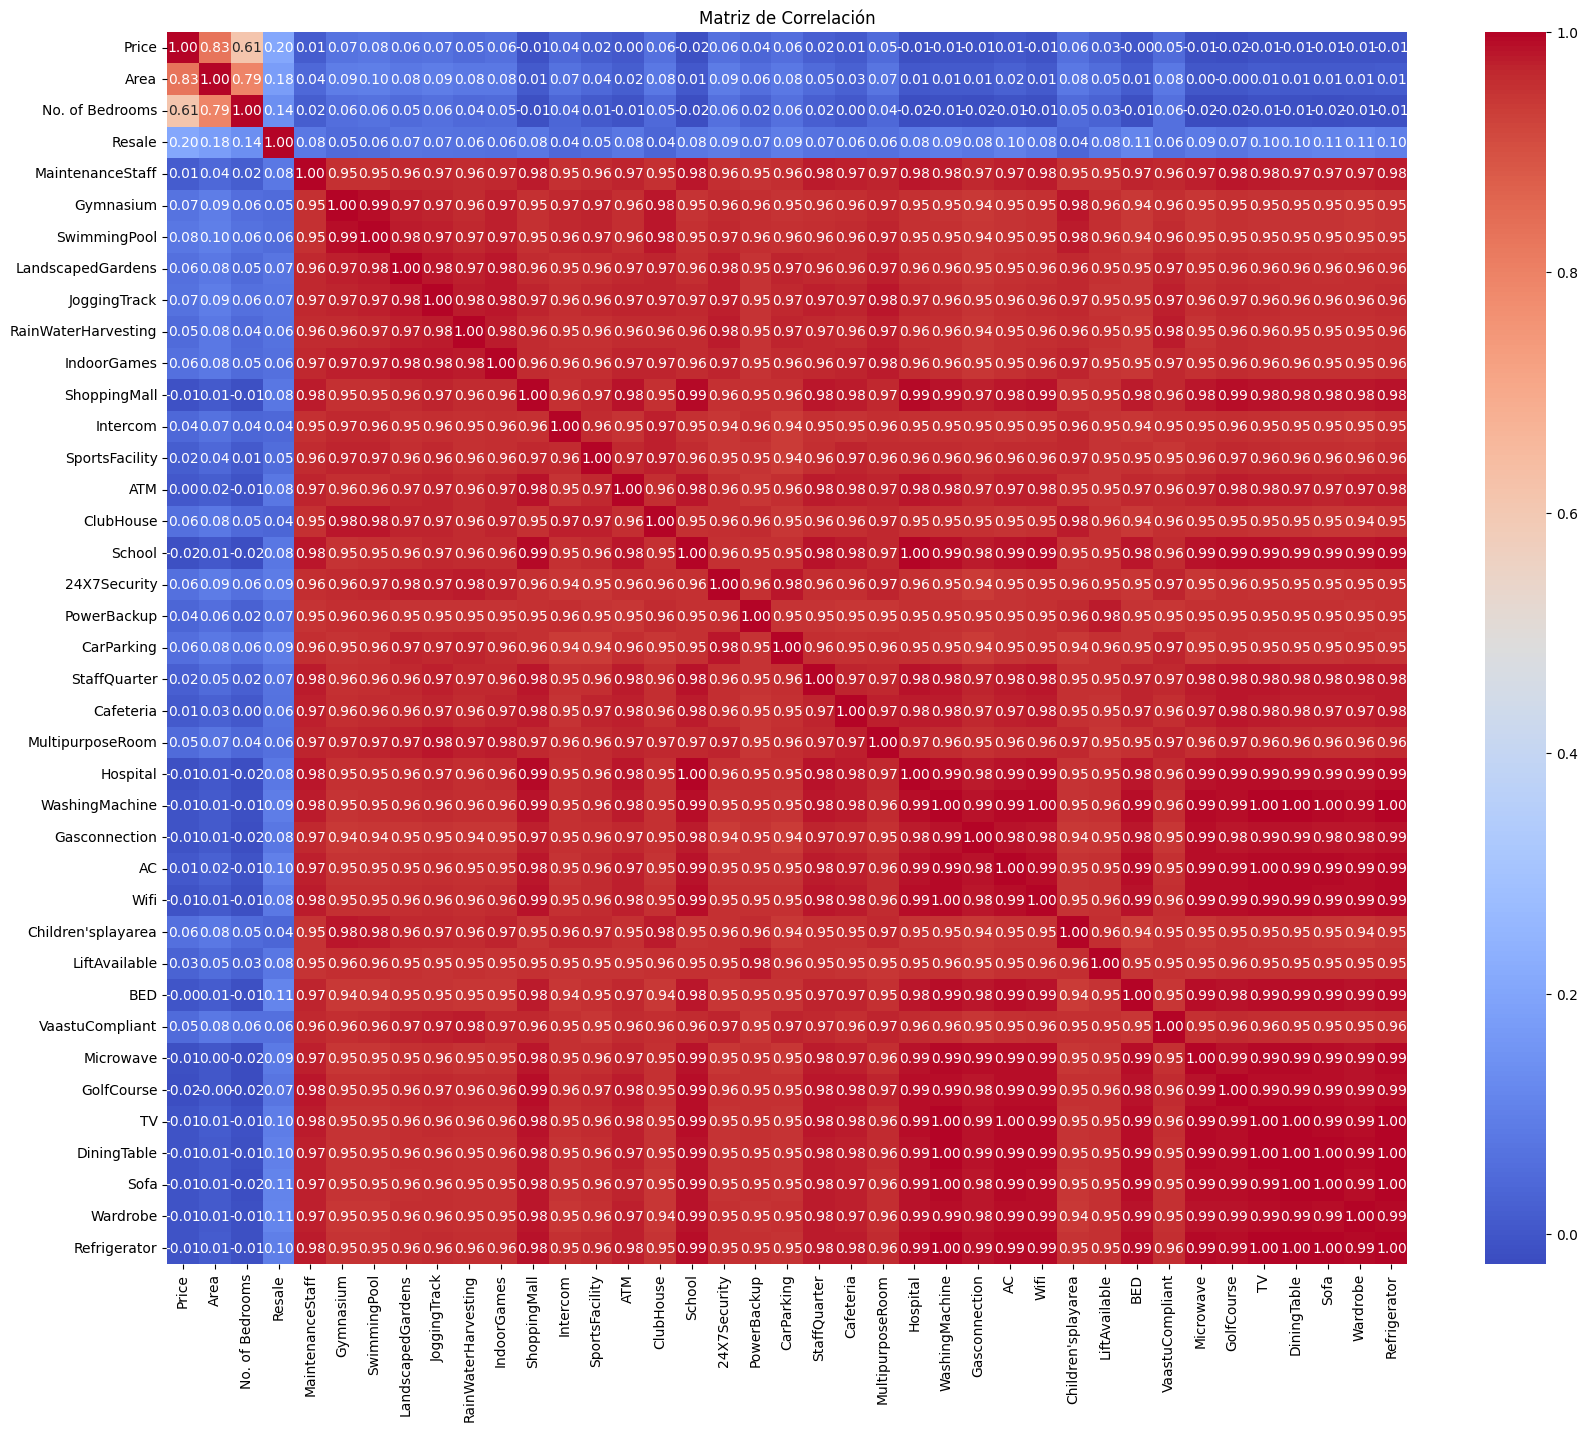

In [7]:
df = dataset.copy()
numeric_ds = df.select_dtypes(include=["int64", "float64"])

corr = numeric_ds.corr()
print(corr)

# HitMap
plt.figure(figsize=(20,16))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

### 1.7 Variance Inflation Factor

The Variance Inflation Factor (VIF) is a measure that helps us identify multicollinearity in a regression model. In simple terms, it tells us how much the variance of an estimated regression coefficient is inflated because a predictor variable is correlated with other predictor variables in the model.

High multicollinearity is a problem because it can make our model's coefficients unstable and difficult to interpret.

- VIF = 1 → Non-collinearity.
- VIF between 1 and 5 → Acceptable.
- VIF > 10 → Serious multicollinearity problem.

In [8]:
df = dataset.copy()    


X = df.select_dtypes(include=["int64", "float64"]).drop(columns=[Column.PRICE.name, Column.LOCATION.name], errors="ignore")
X_with_const = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i + 1) for i in range(len(X.columns))]

print(vif_data)

                feature         VIF
0                  Area    3.001422
1       No. of Bedrooms    2.859169
2                Resale    1.251114
3      MaintenanceStaff   42.085434
4             Gymnasium   76.348622
5          SwimmingPool   69.056489
6     LandscapedGardens   51.394032
7          JoggingTrack   57.399798
8   RainWaterHarvesting   44.847181
9           IndoorGames   52.914516
10         ShoppingMall  108.323335
11             Intercom   28.265128
12       SportsFacility   37.553580
13                  ATM   57.469778
14            ClubHouse   64.194496
15               School  284.671981
16         24X7Security   54.487823
17          PowerBackup   33.878048
18           CarParking   43.998389
19         StaffQuarter   55.308870
20            Cafeteria   51.774113
21     MultipurposeRoom   41.359757
22             Hospital  302.944039
23       WashingMachine  440.926013
24        Gasconnection   58.089827
25                   AC  154.215200
26                 Wifi  136

### 1.8 Checking categorical data

In [9]:
dataset[Column.LOCATION.name].value_counts()

Location
Kukatpally                              166
Kondapur                                149
Manikonda                               115
Nizampet                                106
Gachibowli                               83
                                       ... 
chandrayangutta                           1
Balaji Hills Colony Venkatraya Nagar      1
Janachaitanya Colony                      1
Gurramguda                                1
Paradise Circle                           1
Name: count, Length: 243, dtype: int64